##Consigna

PCA
Se desea incursionar en la tem´atica de clasificaci´on de g´enero musical.
(a) Preprocesamiento de datos:
1. Utilizando load (librosa) cargar los primeros 5 segundos del archivo mi_perro_dinamita.mp3.
Graficar la se˜nal temporal en funci´on del tiempo (en segundos). Repetir con los primeros 5 segundos
del archivo exclusive.mp3.
2. Reproducir los audio utilizando Audio (IPython).
3. Utilizando stft (librosa), graficar para cada se˜nal un espectrograma a partir de imshow.
4. Construir una base de datos de entrenamiento con la el espectrograma de los 5 primeros segundos
de cada canci´on. Generar etiquetas que indiquen de qu´e archivo proven´ıa cada frame. c: Una
buena selecci´on de criterios es utilizar una fft de 2048 puntos, un solapamiento del 75 %, descartar
la parte sim´etrica del espectro y utilizar ventana de hann de la misma cantidad de puntos de la fft.
5. Repetir para el conjunto de datos de validaci´on utilizando 5 segundos de cada canci´on a partir de
los 30 segundos de la misma (es decir, del segundo 30 al 35).
6. Repetir para el conjunto de datos de testeo utilizando 30 segundos a partir del minuto de la misma.
(b) Aprendizaje Supervisado: c: Puede utilizar las implementaciones de sklearn.
1. Entrenar una regresi´on log´ıstica. Indicar el accuracy de testeo. c: Utilice el conjunto de validaci´on
para elegir los hiperpar´ametros de la mejor manera.
2. Repetir para LDA/QDA.
3. Repetir para KNN.
4. Repetir para SVM (kernel rbf).
5. Repetir para ´arboles de decisi´on.
Importante: No se busca que se prueben absolutamente todos los valores posibles, sino que
se expliquen las decisiones tomadas y los razonamientos efectuados en cada caso.
(c) Aprendizaje Supervisado:
1. Utilizando PCA (sklearn) reducir la dimensi´on de los datos a 30 componentes principales.
2. Repetir el inciso (b) utilizando los datos de dimensi´on reducida. Mencionar que m´etodos mejoran,
qu´e m´etodos no y extraer conclusiones.

#PCA - Etchepareborda Baltazar Ariel - TPS-TP06
##(a) Preprocesamiento de datos:
Utilizando load (librosa) cargar los primeros 5 segundos del archivo mi_perro_dinamita.mp3. Graficar la senal temporal en funcion del tiempo (en segundos). Repetir con los primeros 5 segundos del archivo exclusive.mp3.

### (a) Preprocesamiento de datos

En esta primera parte se trabaja con la representación temporal y frecuencial de las señales de audio.  
Cada canción se analiza a través de su transformada corta de Fourier (STFT), que permite obtener la evolución del contenido espectral en función del tiempo.  

La STFT consiste en dividir la señal en fragmentos (ventanas o frames) de duración finita y calcular la transformada de Fourier sobre cada uno de ellos. Esto genera una matriz donde cada columna representa la densidad espectral de un fragmento de tiempo, y cada fila corresponde a una frecuencia.  

El tamaño de ventana (`n_fft = 2048`) define la resolución en frecuencia, mientras que el salto entre ventanas (`hop_length = 512`, equivalente a un solapamiento del 75%) controla la resolución temporal. Ventanas grandes permiten una mayor precisión en frecuencia pero menor precisión temporal, y viceversa.  

Se utiliza una ventana de Hann para suavizar los bordes de cada fragmento y evitar fugas espectrales.  
Luego se descarta la parte simétrica del espectro, ya que para señales reales la mitad positiva de la FFT contiene toda la información útil.  

De este modo, el espectrograma final conserva 1024 frecuencias únicas por frame. Cada frame se interpreta como una observación o muestra para el modelo, y las magnitudes espectrales se usan como variables predictoras.  

Se construyeron tres bases de datos:
- **Entrenamiento**: primeros 5 segundos de cada canción.
- **Validación**: intervalo entre 30 y 35 segundos.
- **Testeo**: intervalo entre 60 y 90 segundos.

Cada frame se etiquetó con su origen (0 para *mi_perro_dinamita*, 1 para *exclusive*).  
El resultado final son tres conjuntos de datos con igual estructura: una matriz de dimensión `[n_frames, 1024]` con una columna adicional que contiene la etiqueta de clase.


In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import IPython.display as ipd

# Descargo los audios
!curl -L -o mi_perro_dinamita.mp3 https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/mi_perro_dinamita.mp3
!curl -L -o exclusive.mp3 https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/exclusive.mp3

# Guardo los primeros 5 segs de cada uno
perro_dinamita, sr1 = librosa.load('mi_perro_dinamita.mp3', duration=5.0, offset=0.0)
exclusive_audio, sr2 = librosa.load('exclusive.mp3', duration=5.0, offset=0.0)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4297k  100 4297k    0     0  6449k      0 --:--:-- --:--:-- --:--:-- 6452k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2912k  100 2912k    0     0  6411k      0 --:--:-- --:--:-- --:--:-- 6401k


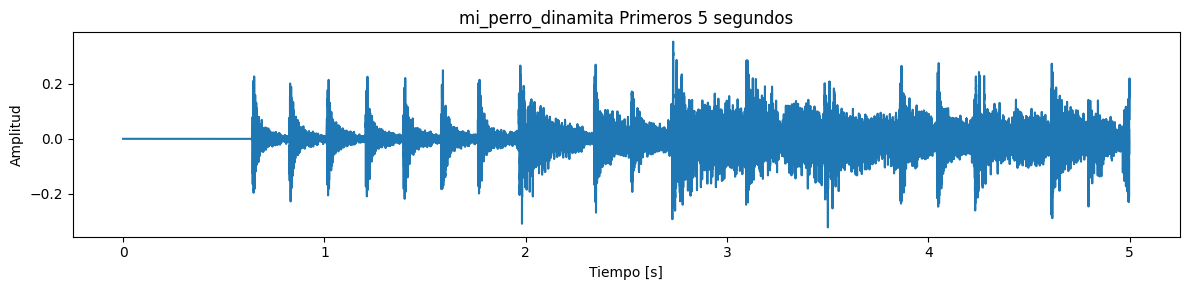

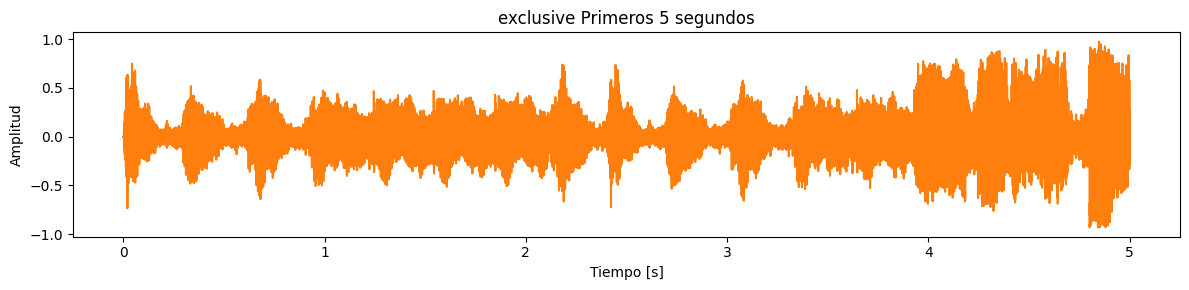

Mi perro dinamita: (110250,), sr=44100
Exclusive: (110250,), sr=44100


In [96]:

# Load first 5 seconds
perro, sr1 = librosa.load("mi_perro_dinamita.mp3", sr=None, duration=5.0, offset=0.0)
exclu, sr2 = librosa.load("exclusive.mp3",           sr=None, duration=5.0, offset=0.0)

# Time axes
t1 = np.arange(len(perro)) / sr1
t2 = np.arange(len(exclu)) / sr2

plt.figure(figsize=(12,3))
plt.plot(t1, perro)
plt.xlabel("Tiempo [s]"); plt.ylabel("Amplitud"); plt.title("mi_perro_dinamita Primeros 5 segundos")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3))
plt.plot(t2, exclu, color="tab:orange")
plt.xlabel("Tiempo [s]"); plt.ylabel("Amplitud"); plt.title("exclusive Primeros 5 segundos")
plt.tight_layout(); plt.show()


print(f"Mi perro dinamita: {perro_dinamita.shape}, sr={sr1}")
print(f"Exclusive: {exclusive_audio.shape}, sr={sr2}")

2. Reproducir los audio utilizando Audio (IPython).

In [97]:
print("mi_perro_dinamita (Primeros 5s)")
ipd.display(ipd.Audio(perro, rate=sr1))

print("exclusive (Primeros 5s)")
ipd.display(ipd.Audio(exclu, rate=sr2))


mi_perro_dinamita (Primeros 5s)


exclusive (Primeros 5s)


3. Utilizando stft (librosa), graficar para cada se˜nal un espectrograma a partir de imshow.

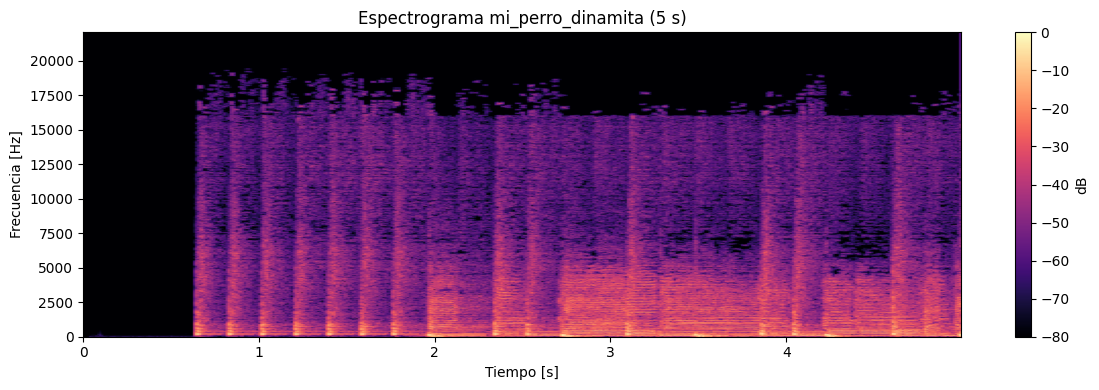

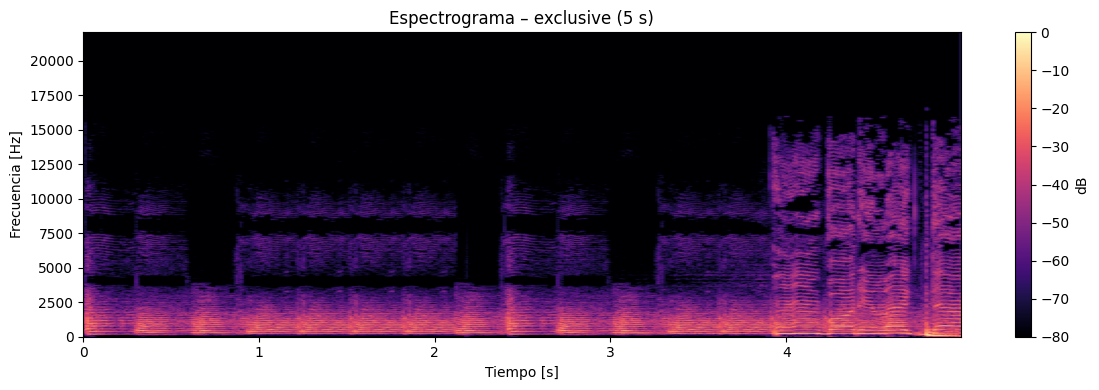

In [98]:
import librosa

n_fft = 2048
hop = int(n_fft * 0.25)   # 75% overlap => hop = 0.25 * n_fft
win = "hann"

# transformada corta de fourier
S1 = np.abs(librosa.stft(perro, n_fft=n_fft, hop_length=hop, window=win))
S2 = np.abs(librosa.stft(exclu, n_fft=n_fft, hop_length=hop, window=win))

# Para visualizar
S1_db = librosa.amplitude_to_db(S1, ref=np.max)
S2_db = librosa.amplitude_to_db(S2, ref=np.max)

times1 = librosa.times_like(S1_db, sr=sr1, hop_length=hop)
freqs1 = librosa.fft_frequencies(sr=sr1, n_fft=n_fft)

times2 = librosa.times_like(S2_db, sr=sr2, hop_length=hop)
freqs2 = librosa.fft_frequencies(sr=sr2, n_fft=n_fft)

plt.figure(figsize=(12,4))
plt.imshow(S1_db, aspect="auto", origin="lower",
           extent=[times1[0], times1[-1], freqs1[0], freqs1[-1]], cmap="magma")
plt.colorbar(label="dB"); plt.xlabel("Tiempo [s]"); plt.ylabel("Frecuencia [Hz]")
plt.title("Espectrograma mi_perro_dinamita (5 s)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
plt.imshow(S2_db, aspect="auto", origin="lower",
           extent=[times2[0], times2[-1], freqs2[0], freqs2[-1]], cmap="magma")
plt.colorbar(label="dB"); plt.xlabel("Tiempo [s]"); plt.ylabel("Frecuencia [Hz]")
plt.title("Espectrograma – exclusive (5 s)")
plt.tight_layout(); plt.show()


Esto es solo para comparar despues porque dio bien y quiero saber si el pedazo de la senial es medianamente parecido para los conjuntos de validacion, testeo y train.

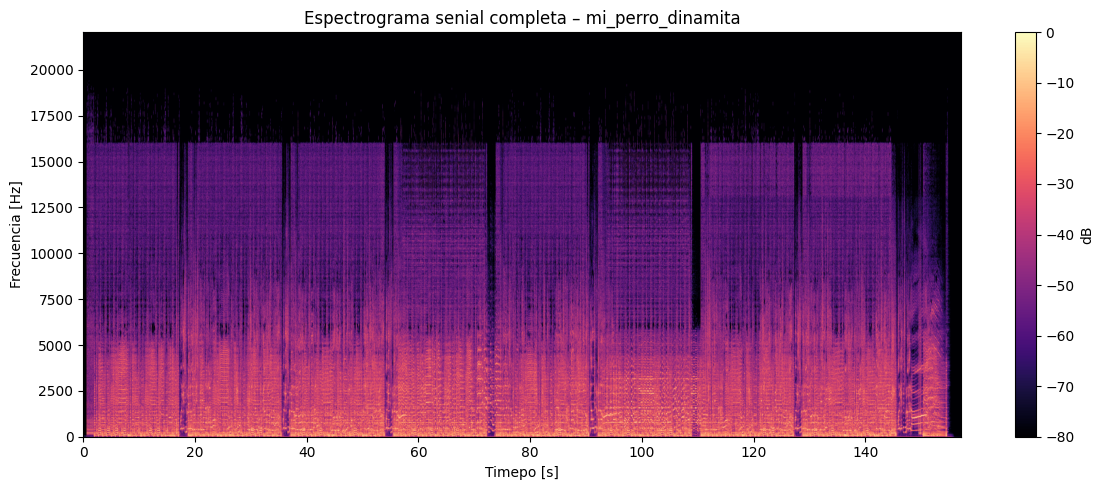

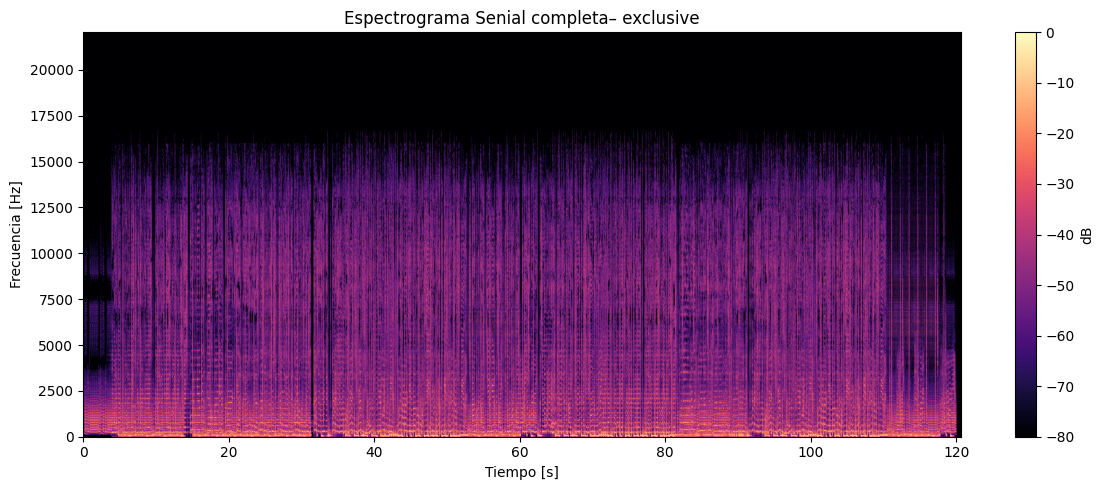

In [99]:

audio_perro_full, sr1_full = librosa.load("mi_perro_dinamita.mp3", sr=None)
audio_exclu_full, sr2_full = librosa.load("exclusive.mp3", sr=None)

S1_full = np.abs(librosa.stft(audio_perro_full, n_fft=n_fft, hop_length=hop, window=win))
S2_full = np.abs(librosa.stft(audio_exclu_full, n_fft=n_fft, hop_length=hop, window=win))


S1_full_db = librosa.amplitude_to_db(S1_full, ref=np.max)
S2_full_db = librosa.amplitude_to_db(S2_full, ref=np.max)


times1_full = librosa.times_like(S1_full_db, sr=sr1_full, hop_length=hop)
freqs1_full = librosa.fft_frequencies(sr=sr1_full, n_fft=n_fft)

times2_full = librosa.times_like(S2_full_db, sr=sr2_full, hop_length=hop)
freqs2_full = librosa.fft_frequencies(sr=sr2_full, n_fft=n_fft)


plt.figure(figsize=(12,5))
plt.imshow(S1_full_db, aspect="auto", origin="lower",
           extent=[times1_full[0], times1_full[-1], freqs1_full[0], freqs1_full[-1]],
           cmap="magma")
plt.colorbar(label="dB")
plt.xlabel("Timepo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.title("Espectrograma senial completa – mi_perro_dinamita")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.imshow(S2_full_db, aspect="auto", origin="lower",
           extent=[times2_full[0], times2_full[-1], freqs2_full[0], freqs2_full[-1]],
           cmap="magma")
plt.colorbar(label="dB")
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.title("Espectrograma Senial completa– exclusive")
plt.tight_layout()
plt.show()


4. Construir una base de datos de entrenamiento con la el espectrograma de los 5 primeros segundos
de cada canci´on. Generar etiquetas que indiquen de qu´e archivo proven´ıa cada frame. c: Una
buena selecci´on de criterios es utilizar una fft de 2048 puntos, un solapamiento del 75 %, descartar
la parte sim´etrica del espectro y utilizar ventana de hann de la misma cantidad de puntos de la fft.
Repetir para el conjunto de datos de validaci´on utilizando 5 segundos de cada canci´on a partir de los 30 segundos de la misma (es decir, del segundo 30 al 35).

In [100]:
###defino parametros, hop length es el solapamento de las ventanas entre si
n_fft = 2048
hop_length = int(n_fft * 0.25)     # 25% overlap
window = 'hann'

def create_dataset(file1, file2, offset, duration, name):
    a1, _ = librosa.load(file1, sr=None, offset=offset, duration=duration)
    a2, _ = librosa.load(file2, sr=None, offset=offset, duration=duration)

    stft1 = librosa.stft(a1, n_fft=n_fft, hop_length=hop_length, window=window)
    stft2 = librosa.stft(a2, n_fft=n_fft, hop_length=hop_length, window=window)

    # keep only positive freqs
    stft1 = stft1[:n_fft // 2, :]
    stft2 = stft2[:n_fft // 2, :]

    spec1 = np.abs(stft1).T
    spec2 = np.abs(stft2).T

    X = np.vstack((spec1, spec2))
    y = np.concatenate((np.zeros(spec1.shape[0]), np.ones(spec2.shape[0])))

    df = pd.DataFrame(X)
    df["label"] = y.astype(int)
    df.to_csv(f"dataset_{name}.csv", index=False)
    print(f"{name}: {df.shape[0]} muestras, {df.shape[1]-1} features")
    return df

train_df = create_dataset('mi_perro_dinamita.mp3', 'exclusive.mp3', offset=0, duration=5, name='train')
val_df   = create_dataset('mi_perro_dinamita.mp3', 'exclusive.mp3', offset=30, duration=5, name='val')
test_df  = create_dataset('mi_perro_dinamita.mp3', 'exclusive.mp3', offset=60, duration=30, name='test')

train: 862 muestras, 1024 features
val: 862 muestras, 1024 features
test: 5168 muestras, 1024 features


In [101]:
#Hago el split de siempre
X_train, y_train = train_df.drop("label", axis=1).values, train_df["label"].values
X_val, y_val     = val_df.drop("label", axis=1).values,   val_df["label"].values
X_test, y_test   = test_df.drop("label", axis=1).values,  test_df["label"].values

#Normalizo para todos menos para bosques
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_val_scal   = scaler.transform(X_val)
X_test_scal  = scaler.transform(X_test)


### (b) Aprendizaje Supervisado

En esta etapa se aplicaron distintos clasificadores supervisados utilizando las implementaciones de `sklearn`.  
El conjunto de entrenamiento se utilizó para ajustar los parámetros de los modelos, el de validación para seleccionar los hiperparámetros óptimos, y el de testeo para evaluar el desempeño final.

Todos los modelos se entrenaron sobre los datos normalizados mediante `StandardScaler`, de modo que cada feature tenga media cero y varianza unitaria. Esto es fundamental para métodos basados en distancias o gradientes, menos para los arboles de decision que como dividen segun features especificas, les es indiferente esa normalizacion como se vio en el tp5.

**Regresión Logística**:  
Se entrenó un clasificador lineal que modela la probabilidad de pertenencia a cada clase mediante una función sigmoide. El parámetro `C` controla la regularización: valores grandes reducen el efecto de la penalización, pudiendo causar sobreajuste; valores pequeños suavizan el modelo. El valor óptimo se determinó a partir del conjunto de validación.

**LDA (Linear Discriminant Analysis)**:  
Asume que cada clase sigue una distribución normal multivariada con una misma matriz de covarianza. La frontera de decisión es lineal. Este método busca maximizar la razón entre la varianza inter-clase y la intra-clase.

**QDA (Quadratic Discriminant Analysis)**:  
Relaja la hipótesis de covarianzas iguales, permitiendo matrices diferentes por clase. En consecuencia, la frontera de decisión es cuadrática.

**K-Nearest Neighbors (KNN)**:  
Clasifica cada muestra según las etiquetas de sus vecinos más cercanos en el espacio de características. El hiperparámetro `k` define el número de vecinos considerados. Valores bajos de `k` pueden sobreajustar el ruido local, mientras que valores grandes tienden a suavizar las fronteras de decisión. La elección se realizó con base en el conjunto de validación.

**SVM con kernel RBF**:  
Este modelo busca maximizar el margen entre clases en un espacio de características. Es lineal pero cuando se le suma el kernel se aumentan las dimensiones.

**Árbol de decisión**:  
Divide recursivamente el espacio de características buscando aquellas separaciones que mejoren la ganancia de informacion, regularizado con el alpha para la funcion de perdida. Tiende mucho al sobreajuste


In [102]:
# ------------------ Regresion logistica ------------------
best_acc = 0
for C in [0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(C=C, max_iter=1000)
    logreg.fit(X_train_scal, y_train)
    acc_val = accuracy_score(y_val, logreg.predict(X_val_scal))
    if acc_val > best_acc:
        best_acc, best_C = acc_val, C

logreg = LogisticRegression(C=best_C, max_iter=1000)
logreg.fit(X_train_scal, y_train)
acc_test = accuracy_score(y_test, logreg.predict(X_test_scal))
print(f"Regresion logistica → mejor C={best_C}, test acc={acc_test:.3f}")

# ------------------ LDA ------------------
best_acc, best_shrink = 0, None
for shrink in [0.1, 0.3, 0.5, 0.7, 0.9]:
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrink)
    lda.fit(X_train_scal, y_train)
    acc_val = accuracy_score(y_val, lda.predict(X_val_scal))
    if acc_val > best_acc:
        best_acc, best_shrink = acc_val, shrink

lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_shrink)
lda.fit(X_train_scal, y_train)
acc_test = accuracy_score(y_test, lda.predict(X_test_scal))
print(f"LDA → shrinkage={best_shrink}, test acc={acc_test:.3f}")

# ------------------ QDA ------------------
best_acc, best_params = 0, None
for reg in [0.1, 0.3, 0.5, 0.7]:
    for tol in [1e-3, 1e-2]:
        qda = QuadraticDiscriminantAnalysis(reg_param=reg, tol=tol)
        qda.fit(X_train_scal, y_train)
        acc_val = accuracy_score(y_val, qda.predict(X_val_scal))
        if acc_val > best_acc:
            best_acc, best_params = acc_val, (reg, tol)

qda = QuadraticDiscriminantAnalysis(reg_param=best_params[0], tol=best_params[1])
qda.fit(X_train_scal, y_train)
acc_test = accuracy_score(y_test, qda.predict(X_test_scal))
print(f"QDA → reg={best_params[0]}, tol={best_params[1]}, test acc={acc_test:.3f}")

# ------------------ KNN ------------------
best_acc, best_k = 0, None
for k in [1,2,3,4, 5,6, 7, 9, 11, 15]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scal, y_train)
    acc_val = accuracy_score(y_val, knn.predict(X_val_scal))
    if acc_val > best_acc:
        best_acc, best_k = acc_val, k

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scal, y_train)
acc_test = accuracy_score(y_test, knn.predict(X_test_scal))
print(f"KNN → k={best_k}, test acc={acc_test:.3f}")

# ------------------ SVM (RBF kernel) ------------------
best_acc, best_params = 0, None
for C in [1, 10, 100]:
    for gamma in [0.001, 0.005, 0.01, 0.02, 0.05]:
        svm = SVC(kernel='rbf', C=C, gamma=gamma)
        svm.fit(X_train_scal, y_train)
        acc_val = accuracy_score(y_val, svm.predict(X_val_scal))
        if acc_val > best_acc:
            best_acc, best_params = acc_val, (C, gamma)

svm = SVC(kernel='rbf', C=best_params[0], gamma=best_params[1])
svm.fit(X_train_scal, y_train)
acc_test = accuracy_score(y_test, svm.predict(X_test_scal))
print(f"SVM (RBF) → C={best_params[0]}, gamma={best_params[1]}, test acc={acc_test:.3f}")


path = DecisionTreeClassifier(random_state=0).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

best_acc, best_alpha = 0, None
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    acc_val = accuracy_score(y_val, tree.predict(X_val))
    if acc_val > best_acc:
        best_acc, best_alpha = acc_val, alpha

# Entrenar el árbol final con el mejor α
tree = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
tree.fit(X_train, y_train)
acc_test = accuracy_score(y_test, tree.predict(X_test))

print(f"Árbol de decisión → mejor α={best_alpha:.5f}, test acc={acc_test:.3f}")


Regresion logistica → mejor C=0.1, test acc=0.902
LDA → shrinkage=0.7, test acc=0.852


/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

QDA → reg=0.7, tol=0.001, test acc=0.920
KNN → k=1, test acc=0.892
SVM (RBF) → C=1, gamma=0.001, test acc=0.936
Árbol de decisión → mejor α=0.00000, test acc=0.770


Guardo para poder comparar despues

In [103]:
logreg_before = logreg
lda_before = lda
qda_before = qda
knn_before = knn
svm_before = svm
tree_before = tree

### (c) Reducción de Dimensión mediante PCA

La cantidad de variables originales (1024 por frame) puede introducir redundancia y correlación entre componentes espectrales adyacentes.  
Para reducir esta complejidad y eliminar correlaciones lineales, se aplicó Análisis de Componentes Principales (PCA) manteniendo las 30 componentes principales.

PCA busca un nuevo sistema de coordenadas donde las direcciones (autovectores) explican la mayor varianza posible de los datos.  
Formalmente, el método consiste en resolver el problema de autovalores de la matriz de covarianza de los datos normalizados:

$$
\Sigma = \frac{1}{n} X^T X, \quad \Sigma v_i = \lambda_i v_i
$$

donde $(v_i)$ son los autovectores (componentes principales) y $\lambda_i$ los autovalores asociados (varianza explicada por cada componente).  
Las nuevas variables $(Z = X V)$ son combinaciones lineales de las originales y están desacopladas entre sí.

Al seleccionar las 30 primeras componentes se conservó aproximadamente el 79% de la varianza total, reduciendo drásticamente la dimensión de entrada sin perder mucha información
relevante.

In [104]:
#Hago pca con 30 componentes
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scal)
X_val_pca   = pca.transform(X_val_scal)
X_test_pca  = pca.transform(X_test_scal)

print(f"Varianza total explicada (30 comp): {pca.explained_variance_ratio_.sum():.2%}")

# ------------------Regresion logisitca------------------
best_acc = 0
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_pca, y_train)
    acc_val = accuracy_score(y_val, model.predict(X_val_pca))
    if acc_val > best_acc:
        best_acc, best_C = acc_val, C

logreg_pca = LogisticRegression(C=best_C, max_iter=1000)
logreg_pca.fit(X_train_pca, y_train)
acc_test = accuracy_score(y_test, logreg_pca.predict(X_test_pca))
print(f"[PCA] Regresion logisitca → C={best_C}, test acc={acc_test:.3f}")

# ------------------ LDA ------------------
best_acc, best_shrink = 0, None
for shrink in [0.1, 0.3, 0.5, 0.7, 0.9]:
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrink)
    lda.fit(X_train_pca, y_train)
    acc_val = accuracy_score(y_val, lda.predict(X_val_pca))
    if acc_val > best_acc:
        best_acc, best_shrink = acc_val, shrink

lda_pca = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_shrink) #parametro para multiplicar por la identidad.
lda_pca.fit(X_train_pca, y_train)
acc_test = accuracy_score(y_test, lda_pca.predict(X_test_pca))
print(f"[PCA] LDA → shrinkage={best_shrink}, test acc={acc_test:.3f}")

# ------------------ QDA ------------------
best_acc, best_params = 0, None
for reg in [0.1, 0.3, 0.5, 0.7]:
    for tol in [1e-3, 1e-2]:
        qda = QuadraticDiscriminantAnalysis(reg_param=reg, tol=tol) # Hace lo mismo que shrinkage pero para k clases. Tol dice cotas para decir que algo es numericamente inestable (solo para el warning)
        qda.fit(X_train_pca, y_train)
        acc_val = accuracy_score(y_val, qda.predict(X_val_pca))
        if acc_val > best_acc:
            best_acc, best_params = acc_val, (reg, tol)

qda_pca = QuadraticDiscriminantAnalysis(reg_param=best_params[0], tol=best_params[1])
qda_pca.fit(X_train_pca, y_train)
acc_test = accuracy_score(y_test, qda_pca.predict(X_test_pca))
print(f"[PCA] QDA → reg={best_params[0]}, tol={best_params[1]}, test acc={acc_test:.3f}")

# ------------------ KNN ------------------
best_acc, best_k = 0, None
for k in [1,2,3,4,5, 7, 9, 11, 15]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    acc_val = accuracy_score(y_val, knn.predict(X_val_pca)) #K es la cantidad de vecinos.
    if acc_val > best_acc:
        best_acc, best_k = acc_val, k

knn_pca = KNeighborsClassifier(n_neighbors=best_k)
knn_pca.fit(X_train_pca, y_train)
acc_test = accuracy_score(y_test, knn_pca.predict(X_test_pca))
print(f"[PCA] KNN → k={best_k}, test acc={acc_test:.3f}")

# ------------------ SVM (RBF) ------------------
best_acc, best_params = 0, None
for C in [1, 10, 100]:
    for gamma in [0.001, 0.005, 0.01, 0.02, 0.05]:
        svm = SVC(kernel='rbf', C=C, gamma=gamma)
        svm.fit(X_train_pca, y_train)
        acc_val = accuracy_score(y_val, svm.predict(X_val_pca)) # gamma chico llega mas cerca, e^-gamma r ->
        if acc_val > best_acc:
            best_acc, best_params = acc_val, (C, gamma)

svm_pca = SVC(kernel='rbf', C=best_params[0], gamma=best_params[1])
svm_pca.fit(X_train_pca, y_train)
acc_test = accuracy_score(y_test, svm_pca.predict(X_test_pca))
print(f"[PCA] SVM (RBF) → C={best_params[0]}, gamma={best_params[1]}, test acc={acc_test:.3f}")

# Calculo los mejores alphas
path = DecisionTreeClassifier(random_state=0).cost_complexity_pruning_path(X_train_pca, y_train)
ccp_alphas = path.ccp_alphas

best_acc, best_alpha = 0, None
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    tree.fit(X_train_pca, y_train)
    acc_val = accuracy_score(y_val, tree.predict(X_val_pca))
    if acc_val > best_acc:
        best_acc, best_alpha = acc_val, alpha

# Entrenar el modelo final con el mejor α
tree_pca = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
tree_pca.fit(X_train_pca, y_train)
acc_test = accuracy_score(y_test, tree_pca.predict(X_test_pca))

print(f"[PCA] Árbol de decisión → mejor α={best_alpha:.5f}, test acc={acc_test:.3f}")
# Despues de pca
logreg_after = logreg_pca
lda_after = lda_pca
qda_after = qda_pca
knn_after = knn_pca
svm_after = svm_pca
tree_after = tree_pca



Varianza total explicada (30 comp): 79.05%
[PCA] Regresion logisitca → C=0.1, test acc=0.900
[PCA] LDA → shrinkage=0.9, test acc=0.878
[PCA] QDA → reg=0.5, tol=0.001, test acc=0.921
[PCA] KNN → k=3, test acc=0.921
[PCA] SVM (RBF) → C=1, gamma=0.01, test acc=0.914
[PCA] Árbol de decisión → mejor α=0.00231, test acc=0.866


In [105]:
#Calculo para los mismos datos los resultados, PCA siempre requiere que esten normalizados
acc_before = {
    "Regresion Logistica": logreg_before.score(X_test_scal, y_test),
    "LDA": lda_before.score(X_test_scal, y_test),
    "QDA": qda_before.score(X_test_scal, y_test),
    "KNN": knn_before.score(X_test_scal, y_test),
    "SVM (RBF)": svm_before.score(X_test_scal, y_test),
    "Arbol de decision": tree_before.score(X_test, y_test)   # unscaled
}

acc_after = {
    "Regresion Logistica": logreg_after.score(X_test_pca, y_test),
    "LDA": lda_after.score(X_test_pca, y_test),
    "QDA": qda_after.score(X_test_pca, y_test),
    "KNN": knn_after.score(X_test_pca, y_test),
    "SVM (RBF)": svm_after.score(X_test_pca, y_test),
    "Arbol de decision": tree_after.score(X_test_pca, y_test)
}
###DF para comparar###
summary_df = pd.DataFrame({
    "Modelo": acc_before.keys(),
    "Accuracy sin PCA": acc_before.values(),
    "Accuracy con PCA": acc_after.values()
})

summary_df["Mejora"] = summary_df["Accuracy con PCA"] - summary_df["Accuracy sin PCA"]
summary_df = summary_df.sort_values("Accuracy con PCA", ascending=False).reset_index(drop=True)

# Display neatly formatted table
summary_df.style.format({
    "Accuracy sin PCA": "{:.3f}",
    "Accuracy con PCA": "{:.3f}",
    "Mejora": "{:+.3f}"
})

,Modelo,Accuracy sin PCA,Accuracy con PCA,Mejora
0,QDA,0.920,0.921,+0.002
1,KNN,0.892,0.921,+0.028
2,SVM (RBF),0.936,0.914,-0.021
3,Regresion Logistica,0.902,0.900,-0.002
4,LDA,0.852,0.878,+0.027
5,Arbol de decision,0.770,0.866,+0.096


##Analisis de resultados:
General: Como con todos los metodos fueron regularizados, no se ven grandes mejoras con respecto a usar PCA con sus direcciones principales. Se puede pensar como una tecnica de regularizacion extra para eliminar la covarianza entre caracteristicas y reducir la dimensionalidad del problema.


Como lo que hace el modelo es calcular autovalores a partir de una matriz de covarianza, tiene sentido que QDA no modifique su eficacia, ya que las distribuciones se modelan como Gaussianas de parametros uk y sigmak, y con esta transformacion que tiene las direcciones principales que tambien se ven como una proyeccion a este espacio, porque sus autovalores se calcuan a partir de la matriz de covarianza pero de dimension menor.


Para KNN el resultado mejora un poco porque descorrelacionar las muestras y conservando solo direcciones principales, encuentra puntos mas espaciados entre si, siendo ahora la distancia una mejor forma de conseguir la clasificacion.


En SVM empeora ya que el buffer se beneficia de un espacio altamente dimensional y al reducir la varianza capturada, el mismo sufre. Regresion logistica tiene sentido que no mejore ya que fue muy beneficiado por la regularizacion previa y probablemente disminuyo los pesos de las features que no aportan informacion.


De todos modos, se ve de los espectrogramas que las frecuencias que respresentan cada una de la canciones son muy diferentes por lo que es esperable que los valores de accuracy sean tan altos en general.
Para donde se ve un gran beneficio marcado, es para arboles de decision que logro mejorar la regularizacion del sistema y prevenir el overfitting tipico (sin PCA el alpha para el arbol de decision es 0 y luego lo sube), al igual que en KNN.


Esto no se ve en el codigo final ya que la consigna pedia regularizar para los metodos. Sin embargo, despues de probar sin regularizar, se confirma mas el razonamiento para prevenir el overfitting como tecnica de regularizacion y proyeccion en direcciones de utilidad, ya que al no regularizar sin PCA vs con PCA las diferencias de rendimiento estaban cerca del 20%, dependiendo del metodo.